# Can the codon frequency be used to predict the DNAtype and Kingdom? This time using Deep Learning.
---
<b>MADS-DL Portfolio-Exam Part 2<br>
Janosch Höfer, 938969</b>

## Table of contents

- [Introduction](#intro) <br>
- [1. Data preparation](#data-prep) <br>
- [2. Parameters](#parameters) <br>
- [3. Split Data](#split) <br>
- [4. Model setup and Hyperparameter Optimization](#model-setup) <br>
   - [4.1. Neural Network](#NN) <br>
   - [4.2. Cross-validation](#CV) <br>
- [5. Model Evaluation](#eval) <br>
   - [5.1. Codon-Kingdom](#eval-king) <br>
   - [5.2. Codon-DNAtype](#eval-dna) <br>
- [6. Result](#result)<br>
- [References](#ref)<br>

## Introduction

In [1]:
# Standard libraries
import copy
import logging
import os
import random
from datetime import timedelta
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# Own classes and functions
from neuralnet import NeuralNet, load_best_model
from utils import DataModule, compute_metrics

In [2]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [3]:
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED, workers=True)

42

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

---
<a id='data-prep'></a>

## 1. Data preparation

In [5]:
data_raw = pd.read_csv("data/codon_usage.csv", sep=",")

C:\Users\j56857\AppData\Local\Temp\ipykernel_23284\3303151036.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv("data/codon_usage.csv", sep=",")


In [6]:
# I removed the steps to identify the invalid rows to make the code more concise
# The CSV indices start at 1, while pandas start 0
bad_rows = [
    data_raw[data_raw["UUU"] == "non-B hepatitis virus"].index[0] + 1,
    data_raw[data_raw["UUU"] == "12;I"].index[0] + 1,
]
data_raw = pd.read_csv("data/codon_usage.csv", sep=",", skiprows=bad_rows)

In [7]:
kingdom = data_raw["Kingdom"]
np.sort(kingdom.unique()), kingdom.unique().size

(array(['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'], dtype=object),
 11)

In [8]:
data_king = data_raw.copy(deep=True)

In [9]:
condition = []
choices = []
# Setup conditions and choices
for count, key in enumerate(kingdom.unique()):
    condition.append(data_raw["Kingdom"] == key)  # unique kingdom 3-letter codes
    choices.append(count)  # integer now assigned to kingdom

data_king["Kingdom_num"] = np.select(condition, choices)
data_king.groupby("Kingdom_num").count()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
Kingdom_num,,,,,,,,,,,,,,,,,,,,,
0,2831,2831,2831,2831,2831,2831,2831,2831,2831,2831,...,2831,2831,2831,2831,2831,2831,2831,2831,2831,2831
1,126,126,126,126,126,126,126,126,126,126,...,126,126,126,126,126,126,126,126,126,126
2,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,...,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919
3,220,220,220,220,220,220,220,220,220,220,...,220,220,220,220,220,220,220,220,220,220
4,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
5,2523,2523,2523,2523,2523,2523,2523,2523,2523,2523,...,2523,2523,2523,2523,2523,2523,2523,2523,2523,2523
6,1345,1345,1345,1345,1345,1345,1345,1345,1345,1345,...,1345,1345,1345,1345,1345,1345,1345,1345,1345,1345
7,2077,2077,2077,2077,2077,2077,2077,2077,2077,2077,...,2077,2077,2077,2077,2077,2077,2077,2077,2077,2077
8,572,572,572,572,572,572,572,572,572,572,...,572,572,572,572,572,572,572,572,572,572


In [10]:
labels = ["Kingdom_num"]
complete_data = data_king.iloc[:, 5:]
final_data = data_king.iloc[:, 5:].drop(labels, axis=1)
targets = data_king.loc[:, labels]

---
<a id='parameters'></a>

## 2. Parameters

In [11]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 75
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

---
<a id='split'></a>

## 3. Split Data

In [12]:
DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)

In [13]:
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

In [14]:
df_dict = {"train": DF_train, "val": DF_val, "test": DF_test}
for key, df_ in df_dict.items():
    print(f"{key}_data:\t size {df_.shape[0]:>3}")

train_data:	 size 7294
val_data:	 size 1824
test_data:	 size 3908


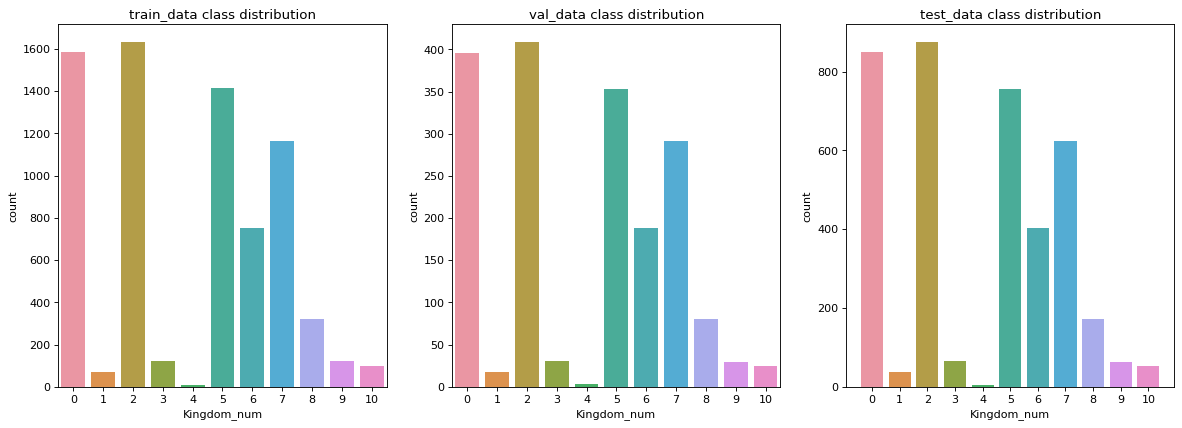

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
for ax, (key, df_) in enumerate(df_dict.items()):
    sns.countplot(data=df_, x=labels[0], ax=axes[ax])
    axes[ax].set(title=f"{key}_data class distribution")
    plt.plot()

---
<a id='model-setup'></a>

## 4. Model setup and Hyperparameter Optimization
<a id='NN'></a>
### 4.1 Neural Network

In [16]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ --host localhost

In [17]:
def train_codons(
    df_train,
    df_val,
    df_test,
    layer_count,
    lr,
    batch_size,
    num_epochs=10,
    core_n=1,
    weights=None,
    dev=False,
    cv=None,
):
    pl.seed_everything(RANDOM_SEED, workers=True)
    data_module = DataModule(
        train_df=df_train,
        test_df=df_test,
        val_df=df_val,
        classes=labels,
        num_workers=core_n,
        batch_size=batch_size,
        device=device,
    )
    model = NeuralNet(
        feature_n, classes_n, lr, layer_count=layer_count, weights=weights, device=device
    )
    if weights is not None:
        w_ind = True
    else:
        w_ind = False
    logger = TensorBoardLogger(
        save_dir="logs",
        name="DL-Exam2",
        version=f"layer={layer_count}-lr={lr}-batchsize={batch_size}-cv={cv}-weights={w_ind}",
    )
    checkpoint_callback = ModelCheckpoint(
        filename="best-checkpoint",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
    )
    stop_callback = EarlyStopping(monitor="val_loss", mode="min", verbose=False, patience=15)
    callbacks = [checkpoint_callback, stop_callback]
    if device.type == "cuda":
        cuda_kwargs = {"accelerator": "gpu", "devices": 1}
    else:
        cuda_kwargs = dict()
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        logger=logger,
        log_every_n_steps=20,
        callbacks=callbacks,
        fast_dev_run=dev,
        enable_progress_bar=False,
        enable_model_summary=False,
        **cuda_kwargs,
    )
    trainer.fit(model, data_module)
    params = {
            "hidden_layer": layer_count,
            "learning_rate": lr,
            "batch_size": batch_size,
            "fold": cv,
            "weights": w_ind,
        }
    if dev:
        return {**params}
    else:
        val_res = trainer.validate(datamodule=data_module, verbose=False, ckpt_path="best")
        test_res = trainer.test(datamodule=data_module, verbose=False, ckpt_path="best")
        
        return {**params, **val_res[0], **test_res[0]}

In [18]:
def hp_optimization(config, df_train, df_val, df_test, num_epochs, dev=False, cv=None):
    runs = list()
    param_count = 0
    for zdx in range(len(config["hidden_layer"])):
        for xdx in range(len(config["learning_rate"])):
            for ydx in range(len(config["batch_size"])):
                for wdx in range(len(config["weights"])):
                    layer_count = config["hidden_layer"][zdx]
                    lr = config["learning_rate"][xdx]
                    batch_size = config["batch_size"][ydx]
                    weights = config["weights"][wdx]
                    if weights is not None:
                        w_ind = True
                    else:
                        w_ind = False
                    start = timer()
                    runs.append(
                        train_codons(
                            df_train=df_train,
                            df_val=df_val,
                            df_test=df_test,
                            layer_count=layer_count,
                            lr=lr,
                            batch_size=batch_size,
                            num_epochs=num_epochs,
                            core_n=core_n,
                            weights=weights,
                            dev=dev,
                            cv=cv,
                        )
                    )
                    param_count += 1
                    model_train_time = timer() - start
                    print(
                        f"Finished training of the HP-combination: {param_count:02d} - fold: {cv}\n"
                        f"Trained on hidden layers: {layer_count:>2} learning-rate: {lr:.4f} batch-size: {batch_size:>3} weights:{w_ind}\n"
                        f"Training time: {str(timedelta(seconds=model_train_time))}"
                    )
    return runs

In [19]:
def combine_to_df(left_array, right_array, labels):
    df = pd.merge(
        pd.DataFrame(left_array).iloc[:, :-1],
        right_array.reset_index().drop(columns="index")[labels],
        left_index=True,
        right_index=True,
    )
    return df

<a id='CV'></a>
### 4.2 Cross-Validation

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [21]:
king_weights = compute_class_weight(
    class_weight="balanced",
    classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
    y=targets.iloc[:, 0].ravel(),
)
king_weights_t = torch.Tensor(king_weights)

In [ ]:
config = {
    "hidden_layer": [3],
    "learning_rate": [1e-2, 1e-3],
    "batch_size": [128],
    "weights": [None, king_weights_t],
}
runs_cv = list()
for idx, (train_index, val_index) in enumerate(
    skf.split(DF_train_full.drop(columns=labels), DF_train_full[labels])
):
    X_train, X_val = DF_train_full.iloc[train_index], DF_train_full.iloc[val_index]
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.transform(X_val)
    X_test_sc = scaler.transform(DF_test)  # Using initial DF_test because it stays the same

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, DF_test, labels)
    runs_cv += hp_optimization(
        config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=False,
        cv=idx,
    )

Finished training of the HP-combination: 01 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size: 128 weights:False
Training time: 0:17:46.040250
Finished training of the HP-combination: 02 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size: 128 weights:True
Training time: 0:31:35.873606
Finished training of the HP-combination: 03 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size: 128 weights:False
Training time: 0:37:22.309376
Finished training of the HP-combination: 04 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size: 128 weights:True
Training time: 0:37:43.179599
Finished training of the HP-combination: 01 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size: 128 weights:False
Training time: 0:14:53.179611
Finished training of the HP-combination: 02 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size: 128 weights:True
Training time: 0:33:27.049632


In [ ]:
pd.DataFrame(runs_cv).head()

In [ ]:
pd.DataFrame(runs_cv).to_parquet(path="data/cv_hp_optimization", engine="pyarrow")

In [ ]:
cv_hp_result_df = pd.read_parquet(path="data/cv_hp_optimization", engine="pyarrow")

In [ ]:
cv_hp_results_mean = (
    cv_hp_result_df.groupby(["hidden_layer", "learning_rate", "batch_size", "weights"])
    .mean()
    .reset_index()
)

In [ ]:
cv_hp_results_mean

In [ ]:
cv_hp_results_mean[cv_hp_results_mean["val_balanced_accuracy"] > 0.9].sort_values(
    ["val_balanced_accuracy", "val_accuracy"], ascending=False
)

In [ ]:
best_params = cv_hp_results_mean[
    cv_hp_results_mean["val_balanced_accuracy"] == cv_hp_results_mean["val_balanced_accuracy"].max()
]
best_params

---
<a id='eval'></a>

## 5. Model Evaluation
<a id='eval-king'></a>
### 5.1 Kingdom prediction

In [ ]:
best_config = best_params.iloc[:1, :].to_dict("list")

In [ ]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 100  # Now using more epochs
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

In [ ]:
if best_params["weights"].iloc[0]:
    king_weights = compute_class_weight(
        class_weight="balanced",
        classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
        y=targets.iloc[:, 0].ravel(),
    )
    best_config["weights"] = [torch.Tensor(king_weights)]
else:
    best_config["weights"] = [None]

In [ ]:
skf_eval = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
runs_eval = list()
king_data = dict()
for idx, (train_index, test_index) in enumerate(
    skf_eval.split(complete_data.drop(columns=labels), complete_data[labels])
):
    X_train_full, X_test = complete_data.iloc[train_index], complete_data.iloc[test_index]
    X_train, X_val, = train_test_split(
        X_train_full,
        test_size=val_size,
        shuffle=True,
        random_state=RANDOM_SEED,
        stratify=X_train_full[labels],
    )
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.fit_transform(X_val)
    X_test_sc = scaler.transform(X_test)

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, X_test, labels)
    runs_eval += hp_optimization(
        best_config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=False,
        cv=f"final_king_{idx}",
    )
    king_data[f"final_king_{idx}"] = [DF_train_sc, DF_val_sc, DF_test_sc]

In [ ]:
pd.DataFrame(runs_eval).head()

In [ ]:
pd.DataFrame(runs_eval).to_parquet(path="data/eval_king", engine="pyarrow")

In [ ]:
eval_king_result_df = pd.read_parquet(path="data/eval_king", engine="pyarrow")

In [ ]:
eval_king_result_df

In [ ]:
best_model_key = "final_king_1"
best_config = best_params.iloc[:1, :].to_dict("list")
best_model = load_best_model(
    best_config,
    NeuralNet,
    feature_n=feature_n,
    classes_n=classes_n,
    device=device,
    cv=best_model_key,
)
king_res = list()
for key, items in king_data.items():
    if key == best_model_key:
        for res_list in items:
            king_res.append(
                compute_metrics(
                    best_model,
                    torch.tensor(res_list.drop(columns=labels).values, dtype=torch.float),
                    res_list[labels],
                )
            )

In [ ]:
pd.DataFrame(king_res)

In [ ]:
ConfusionMatrixDisplay(king_res[-1]["confusion_matrix"]).plot()
plt.show()

<a id='eval-dna'></a>
### 5.2 DNAtype prediction

In [ ]:
dnatype = data_raw["DNAtype"]
np.sort(dnatype.unique()), dnatype.unique().size

In [ ]:
data_dna = data_raw.copy(deep=True)

In [ ]:
condition = []
choices = []
# Setup conditions and choices
for count, key in enumerate(dnatype.unique()):
    condition.append(data_raw["DNAtype"] == key)  # unique kingdom 3-letter codes
    choices.append(count)  # integer now assigned to kingdom

data_dna["DNAtype_num"] = np.select(condition, choices)
data_dna.groupby("DNAtype_num").count()

In [ ]:
data_drop_dna = data_dna[data_dna["DNAtype"].isin([0, 1, 2, 4])]
data_raw[~data_raw["DNAtype"].isin([0, 1, 2, 4])].count()

In [ ]:
labels = ["DNAtype_num"]
complete_data = data_drop_dna.iloc[:, 5:]
targets = data_drop_dna.loc[:, labels]
classes_n = len(targets.drop_duplicates(subset=labels))

In [ ]:
DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

In [ ]:
df_dict = {"train": DF_train, "val": DF_val, "test": DF_test}
for key, df_ in df_dict.items():
    print(f"{key}_data:\t size {df_.shape[0]:>3}")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
for ax, (key, df_) in enumerate(df_dict.items()):
    sns.countplot(data=df_, x=labels[0], ax=axes[ax])
    axes[ax].set(title=f"{key}_data class distribution")
    plt.plot()

In [ ]:
# Adjust labels
complete_data[labels] = np.where(complete_data[labels] == 4, 1, complete_data[labels])
targets = complete_data.loc[:, labels]

In [ ]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 100  # Now using more epochs
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

In [ ]:
best_params

In [ ]:
if best_params["weights"].iloc[0]:
    dna_weights = compute_class_weight(
        class_weight="balanced",
        classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
        y=targets.iloc[:, 0].ravel(),
    )
    best_config["weights"] = [torch.Tensor(dna_weights)]
else:
    best_config["weights"] = [None]

In [ ]:
runs_eval = list()
dna_data = dict()
for idx, (train_index, test_index) in enumerate(
    skf_eval.split(complete_data.drop(columns=labels), complete_data[labels])
):
    X_train_full, X_test = complete_data.iloc[train_index], complete_data.iloc[test_index]
    X_train, X_val, = train_test_split(
        X_train_full,
        test_size=val_size,
        shuffle=True,
        random_state=RANDOM_SEED,
        stratify=X_train_full[labels],
    )
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.fit_transform(X_val)
    X_test_sc = scaler.transform(X_test)

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, X_test, labels)
    runs_eval += hp_optimization(
        best_config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=False,
        cv=f"final_dna_{idx}",
    )
    dna_data[f"final_dna_{idx}"] = [DF_train_sc, DF_val_sc, DF_test_sc]

In [ ]:
pd.DataFrame(runs_eval).head()

In [ ]:
pd.DataFrame(runs_eval).to_parquet(path="data/eval_dna", engine="pyarrow")

In [ ]:
eval_dna_result_df = pd.read_parquet(path="data/eval_dna", engine="pyarrow")

In [ ]:
eval_dna_result_df

In [ ]:
best_model_key = "final_dna_1"
best_config = best_params.iloc[:1, :].to_dict("list")
best_model = load_best_model(
    best_config,
    NeuralNet,
    feature_n=feature_n,
    classes_n=classes_n,
    device=device,
    cv=best_model_key,
)

In [ ]:
dna_res = list()
for key, items in dna_data.items():
    if key == best_model_key:
        for res_list in items:
            dna_res.append(
                compute_metrics(
                    best_model,
                    torch.tensor(res_list.drop(columns=labels).values, dtype=torch.float),
                    res_list[labels],
                )
            )

In [ ]:
pd.DataFrame(dna_res)

In [ ]:
ConfusionMatrixDisplay(dna_res[-1]["confusion_matrix"]).plot()
plt.show()

---
<a id='result'></a>

## 6. Result